In [1]:
# 设置包环境，导入包
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('./')

import math
import numpy as np
import copy
import matplotlib.pyplot as plt
#from tqdm import tqdm_notebook as tqdm
from tqdm import   tqdm

# 实验计划
1、生成跟踪数据，存储方式$x_{t}^* = [{x_{1,t}^*}^T,{x_{2,t}^*}^T,{x_{3,t}^*}^T]$。代表三个随时间移动的点。每个点的移动轨迹为$x_{i,t}^* = \left[\begin{array}{c}
\kappa_i \sin \left(\omega_i t+\nu_i\right) \\
\omega_i \kappa_i \cos \left(\omega_i t+\nu_i\right)
\end{array}\right]^T$。

2、建立信息观测模型。节点i在t时刻感知到的关于以上三个节点的信息为$y_{i,t} = C_{i} x_{t}^*$。因此时间t时刻全局优化函数为$f_{t}(x) = \frac{1}{n} \sum_{i=1}^{n} \| C_i x - y_{i,t} \|^2$。

3、获取函数的梯度评估，使用零阶Oracle或者一阶梯度。针对$f_{i,t}(x)=\| C_i x - y_{i,t} \|^2$。

4、生成网络，可以选择每一个时间t都是强连通的序列，也可以构造循环的和B-强连通序列。

5、写算法开始实验。

## 算法里面的参数设置
#### 模型参数
1、衰减步长decay_step = $\frac{1}{4\sqrt{t+1}}$。

2、$\mu = 10^{-3} \in [0, r\xi]$。

#### 信息模型参数
1、模型的幅度$\kappa_{i}$

2、模型的评率$\omega_{i}$

3、模型的相位$\nu_{i}$
#### 网络参数
1、网络智能体个数agent_num

2、网络密度net_pro

In [2]:
# 优化参数
decay_step_0 = 0.25
def decay_step(t, is_constant_step=False):
    return decay_step_0 * (1 / (t+1)**0.5) if not is_constant_step else decay_step_0
#u = 10e-3
# init_value = 0
iter_num = 10000
u=6/iter_num
# is_project = True
# 信息模型参数
num = 3
def set_m_p(low, high, is_int=False):
    p = list()
    for i in range(num):
        rd = np.random.rand()
        v = rd * (high - low) + low
        if is_int:
            v = int(v)
        p.append(v)
    return p
#k_ = set_m_p(0, 3)
k_=[0.5, 1, 1.5]
w_ = set_m_p(2*math.pi / 4000, 2*math.pi / 2000, is_int=False)
v_ = set_m_p(0, math.pi)
mat_scale = 1
dynamic_C = True
# 网络参数
agent_num = 5
net_pro = 0.5

## 生成数据在t时刻所在的位置信息
def real_position(t, num):
    
生成t时刻，点i所在的位置信息，num表示一共生成m个点的信息。

In [3]:
# sin和cos曲线 
def real_position_wave(t):
    positions = list()
    for i in range(num):
        p = [k_[i]*math.sin(w_[i]*t+v_[i]), w_[i]*k_[i]*math.cos(w_[i]*t+v_[i])]
        positions.append(p)
    positions = np.array(positions)
    x = positions.reshape(-1,1)
    return positions, x

# 折线
module_value = set_m_p(4000, 5000, is_int=True)
def real_position_zhexian(t):
    positions = list()
    for i in range(num):
        p = [k_[i] * (t % module_value[i]), w_[i] * k_[i]*( int(t+v_[i])%module_value[i] )]
        positions.append(p)
    positions = np.array(positions)
    x = positions.reshape(-1,1)
    return positions, x

real_position = real_position_wave

# 生成传感器的观测模型
利用公式$y_{i,t}=C_i x_{t}^*$,表示传感器i观测到的在t时刻三个信号点的感知信息。

思路：随机生成$C_i \in \mathbb{R^{1 \times m}}$的感知矩阵agent_num个，m是num个点的位置信息的简单拼接所得向量的维数。

In [4]:
# 模拟第t次时在信息传递模型下各个节点对应的感知矩阵
agent_mat = list()
r = 1
c = num * 2
for i in range(agent_num):
    mat_ = np.random.randn(r,c) * mat_scale
    agent_mat.append(mat_)
constant_sensor = np.array(agent_mat).reshape(agent_num,-1)
def design_sensor(dynamic=dynamic_C):
    agent_mat = list()
    r = 1
    c = num * 2
    for i in range(agent_num):
        mat_ = np.random.randn(r,c) * mat_scale
        agent_mat.append(mat_)
    agent_mat = np.array(agent_mat).reshape(agent_num,-1)
    return agent_mat if dynamic else constant_sensor

## 获取代价函数的梯度评估
针对$f_{i,t}(x)=\| C_i x - y_{i,t} \|^2$进行梯度评估。

1、零阶Oracle的评估梯度计算公式为
$$
\hat{g}_{i, t}(x)=\frac{m}{\mu}\left(f_{i, t}\left(x+\mu \zeta_{i, t}\right)-f_{i, t}(x)\right) \zeta_{i, t},
$$
转化为该问题公式如下
$$
\hat{g}_{i, t}(x)=\frac{m}{\mu}\left(\| C_{i,t}\left(x+\mu \zeta_{i, t}\right) - y_{i,t} \|^2- \| C_{i,t}x - y_{i,t} \|^2 \right) \zeta_{i, t},
$$
其中$x \in (1-\xi)\Omega$，$\zeta_{i,t} \in \mathbb{S^m}$。

2、一阶梯度的评估梯度计算公式为
$$
\nabla f_{i,t}(x) = 2 C_{i,t}^T (C_{i,t} x - y_{i,t})
$$

In [5]:
# 在这里定义一些辅助函数

# 随机获取维度为m的一个单位向量 
def unit_vector_gaussian(m):
    rd_vec = np.random.randn(m)
    squre_sum = np.linalg.norm(rd_vec)
    rd_vec = rd_vec / squre_sum
    return rd_vec.reshape(m,-1)

def unit_vector_uniform(m):
    rd_vec = np.random.uniform(-1, 1, m)
    squre_sum = np.linalg.norm(rd_vec)
    rd_vec = rd_vec / squre_sum
    return rd_vec.reshape(m,-1)

# 定义一个zeta生成开关
unit_vector = unit_vector_uniform

In [6]:
def zero_oracle(x, y, c_i):
    # 确保形状不会错
    zeta = unit_vector(num * 2)
    x = x.reshape(-1,1)
    c_i = c_i.reshape(1,-1)
    # zero_oracle求解算法
    m = len(x.flatten())
    oracle = (m / u) * (
        np.linalg.norm(np.dot(c_i,(x + u * zeta)) - y)**2 - np.linalg.norm(np.dot(c_i, x) - y)**2
    ) * zeta
    return oracle
    
def first_order(x, y, c_i):
    # 确保形状不会错
    x = x.reshape(-1,1)
    c_i = c_i.reshape(1,-1)
    # 一阶求解算法
    grad = 2 * (np.dot(c_i, x) - y) * c_i.T
    return grad
# 定义一个梯度开关
grad_estimate = zero_oracle

def net_grad_estimate(X, Y, C):
    re = np.ones((agent_num, num * 2))
    for i in range(agent_num):
        re[i,:] = grad_estimate(X[i], Y[i], C[i]).reshape(1,-1)
    return re

# zero_oracle(real_position(1)[1], 0, design_sensor(1)[0])
# first_order(real_position(1)[1], 0, design_sensor(1)[0])

## 随时刻变化的网络
1、使用任意时刻t都是强连通的网络

2、使用T时间段内组成强连通的网络，然后循环使用这些网络

3、使用完全随机的网络，不一定要求全连通（可以直观想象在某个足够大的T下能够组成强连通）

我使用第1种先做一个实现，然后切换到2，最后是否切换到3看时间。

In [7]:
from network import NetManager 

ModuleNotFoundError: No module named 'network'

In [ ]:
# 定义一个获取t时刻的网络结构的函数
net = NetManager()
def t_net_1():
    mat, G = net.generate_direct_graph(nodes=agent_num,density=net_pro)
    return mat, G

# 定义一个开关，用后续切换三个版本的网络
t_net = t_net_1

## 开始做实验
1、初始化参数$X_{t} = [x_{1,t},x_{2,t},...,x_{n,t}]^T$，其中t=0。

2、获取观测到的值$y_{i,t} = C_{i,t}x_{i,t}^*$。注意design_sensor(t)如果不传值则每次的C_{i,t}都是相同的，传值则不同。

3、计算评估的梯度，使用$X_{t}和y_{i,t}$去计算梯度。

##### 算法迭代过程
$$
\begin{aligned}
\phi_{i, t+1} & =\sum_{j=1}^n a_{i j, t} \phi_{j, t} \\
q_{i, t+1} & = \sum_{j=1}^n b_{i j, t} (q_{j, t} + v_{j,i})+\frac{1}{\phi_{i, t+1}} \hat{g}_{i, t}\left(x_{i, t}\right) \\
x_{i, t+1} & =\Pi_{(1-\xi) \Omega}^{\mathbb{O}}\left(q_{t+1}^i, \alpha_t\right)
\end{aligned}
$$
其中
$$
\Pi_{(1-\xi) \Omega}^{\mathbb{O}}(q, \alpha)=\underset{u \in (1-\xi) \Omega}{\operatorname{argmin}}\left\{\langle q, u\rangle+\frac{\mathbb{O}(u)}{\alpha}\right\} \\
\mathbb{O}(u) = \frac{1}{2} \| u \|^{2}
$$
其中最后一步的计算方法如下
$$
f(x) = \langle q, u \rangle+\frac{\phi(u)}{\alpha} = q_1 u_1 + q_2 u_2  + \frac{1}{2\alpha} (u_1^2 + u_2^2)  \\
f^{'}(x)|u_1 = q_1 + \frac{1}{\alpha} u_1 = 0 \\
f^{'}(x)|u_2 = q_2 + \frac{1}{\alpha} u_2 = 0 \\
u_1 = -\alpha q_1, u_2 = -\alpha q_2 \\
u_1 = \mathcal{P}_{(1-\xi) \Omega}(-\alpha q_1) \\
u_2 = \mathcal{P}_{(1-\xi) \Omega}(-\alpha q_2) \\
$$
第二个式子为了编码方便可以化简等价为如下式子
$$
q_{i, t+1} =\frac{1}{\phi_{i,t+1}} \sum_{j=1}^n \phi_{j,t} a_{i j, t}(q_{j, t} + v_{j,i})+\frac{1}{\phi_{i, t+1}}  \hat{g}_{i, t}\left(x_{i, t}\right)
$$
其中$
b_{i j, t} \triangleq \frac{1}{\phi_{i, t+1}} a_{i j, t} \phi_{j, t}
$

约束为$-k_i \leq x_{i1} \leq k_i$和$- w_i \times k_i \leq x_{i2} \leq w_i \times k_i$。

为了实现优化算法，我们需要先定义一个投影算法，满足上述投影要求。

In [ ]:
# 需要先定义一个投影算法，实现上述投影算法
low_vector = np.ones((1,num*2))
low_vector[:,[0,2,4]] = -np.array(k_)
low_vector[:,[1,3,5]] = -np.array(k_) * np.array(w_)
low_vector = low_vector.reshape(-1,1)

high_vector = np.ones((1,num*2))
high_vector[:,[0,2,4]] = np.array(k_)
high_vector[:,[1,3,5]] = np.array(k_) * np.array(w_)
high_vector = high_vector.reshape(-1,1)

def projection(x, low_vector=low_vector, high_vector=high_vector):
    re = x
    re[x < low_vector] = low_vector[x < low_vector]  # 将小于low_vector的部分对应的low_vector的值
    re[x > high_vector] = high_vector[x > high_vector]  # 将大于于high_vector的部分对应的high_vector的值
    return re

def net_projection(X, low_vector=low_vector, high_vector=high_vector):
    re = copy.deepcopy(X)
    for i in range(agent_num):
        re[i,:] = projection(X[i,:].reshape(-1,1), low_vector=low_vector, high_vector=high_vector).reshape(1,-1)
    return re

def xi_projection(x, t, low_vector=low_vector, high_vector=high_vector):
    re = x
    re[x < (1 - 1 / (t+1)) * low_vector] = low_vector[x < (1 - 1 / (t+1)) * low_vector]  # 将小于low_vector的部分对应的low_vector的值
    re[x > (1 - 1 / (t+1)) * high_vector] = high_vector[x > (1 - 1 / (t+1)) * high_vector]  # 将大于于high_vector的部分对应的high_vector的值
    return re

def xi_net_projection(X, t, low_vector=low_vector, high_vector=high_vector):
    re = copy.deepcopy(X)
    for i in range(agent_num):
        re[i,:] = xi_projection(X[i,:].reshape(-1,1), t, low_vector=low_vector, high_vector=high_vector).reshape(1,-1)
    return re


# 获取扰动方差
def get_bt():
    return  np.random.normal(5, 1e-1)

# 为t时刻提供拉普拉斯扰动
def get_laplace(loc, scale):
    return np.random.laplace(loc, scale, size=(agent_num, num * 2))

# 为t时刻提供高斯扰动
def get_gaussian(avg, varance):
    return np.random.normal(avg, varance, size=(agent_num, num * 2))

# 对偶投影算子
def dual_project_operator(Q, step, t):
    X = - step * Q
    return xi_net_projection(X, t)


perturbation = get_laplace

In [ ]:
# 初始化信息传递模型参数
x_star = dict() #t时刻的真实位置信息
_, x_star[0] = real_position(0)   
C = dict()
C[0] = design_sensor(dynamic_C)
Y = dict() # t时刻各个节点的观测值
Y[0] = np.dot(C[0], x_star[0])

# 初始优化模型参数
Q = dict()
Q[0] = np.random.randn(agent_num, num * 2)
X = dict()
X[0] = dual_project_operator(Q[0], decay_step(0), 0)
phi = dict()
phi[0] = np.ones((agent_num,1))


# 初始化网络参数
NET = dict()
NET[0], _ = t_net()
# zero_oracle(X[0][0], Y[0][0], C[0][0])
print(real_position(4)[1])

[[ 0.32377076]
 [-0.00073923]
 [ 0.35191259]
 [ 0.00168986]
 [ 0.27353904]
 [-0.00243326]]


In [ ]:
# 迭代过程正式开始
process_bar = tqdm(range(iter_num))
for iter_ in process_bar:
    # 算法更新部分
    phi[iter_+1] = np.dot(NET[iter_], phi[iter_])   # step_1
    
    B = (NET[iter_] * phi[iter_].T) / phi[iter_+1]

    Q[iter_+1] = np.dot(B, (Q[iter_] + perturbation(0, get_bt()))) + (net_grad_estimate(X[iter_], Y[iter_], C[iter_]) / phi[iter_+1]) # step_2

    X[iter_+1] = dual_project_operator(Q[iter_+1], decay_step(iter_), iter_)  # step_3

        
    
    # 获取下一时刻的网络状态NET[iter_+1]和信号传递模型中的x_star[iter_+1],C[iter_+1],Y[iter_+1]。
    NET[iter_+1],_ = t_net()
    _, x_star[iter_+1] = real_position(iter_+1)
    C[iter_+1] = design_sensor(dynamic_C)
    Y[iter_+1] = np.dot(C[iter_+1], x_star[iter_+1])
    
    process_bar.set_postfix(iter_=iter_, step = decay_step(iter_))

 29%|██████████████▏                                  | 2902/10000 [00:02<00:06, 1175.39it/s, iter_=2974, step=0.00458]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████████████████████████████████▌             | 7270/10000 [00:06<00:02, 1198.24it/s, iter_=7288, step=0.00293]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1223.08it/s, iter_=9999, step=

## 可视化模型训练结果
1、绘制一个$\mathcal{R}_j^d(T)=\sum_{t=0}^T F_t\left(x_{j, t}\right)-\sum_{t=0}^T F_t\left(x_t^{\star}\right)$

其中$F_t(x)=\frac{1}{n} \sum_{i=1}^n\left\|C_i x-y_{i, t}\right\|^2$

##### 获取dynamic_regret序列的函数

In [ ]:
# 计算t时刻使用第agent个节点结算的F值。(1 / agent_num)
def F(C, X, Y, agent, t):
    C_t = C[t]
    X_t = np.dot(np.ones((agent_num,1)), X[t][agent].reshape(1,-1))
    Y_t = Y[t]

    F_value = np.linalg.norm(
        np.diag(np.dot(C_t, X_t.T)).reshape(-1,1) - Y_t
    )**2
    return F_value

# 计算t时刻最优的F_star值
def F_star(C, x_star, Y, t):
    C_t = C[t]
    X_t = np.dot(np.ones((agent_num,1)), x_star[t].reshape(1,-1))
    Y_t = Y[t]

    F_value =  np.linalg.norm(
        np.diag(np.dot(C_t, X_t.T)).reshape(-1,1) - Y_t
    )
    return F_value

# 获取第i（agent）个节点的dynamic_regret
def dynamic_regret(agent, T):
    left = 0
    right = 0
    for t in range(T+1):
        left = left + F(C, X, Y, agent, t)
        right = right + F_star(C, x_star, Y, t)
    regret = left - right
    return regret

# 获取第i（agent）个节点的regret序列
def average_dynamic_regret_sequence(agent, T):
    regret_sequence = list()
    for t in range(T+1):
        regret_sequence.append(dynamic_regret(agent, t) / (t+1))
    return regret_sequence

# average_dynamic_regret_sequence(0,100)

##### 获取信号源位置的函数

In [ ]:
def target(T, dim=0):
    x_star_sequence = list()
    for t in range(T+1):
        x_star_sequence.append(x_star[t][dim][0])
    return x_star_sequence

def track_ans(agent, T, dim=0):
    track_sequence = list()
    for t in range(T+1):
        track_sequence.append(X[t][agent][dim])
    return track_sequence
# target(10, dim=0)
# track_ans(0, 10, dim=0)

##### 绘制图像
1、绘制x的跟踪图像

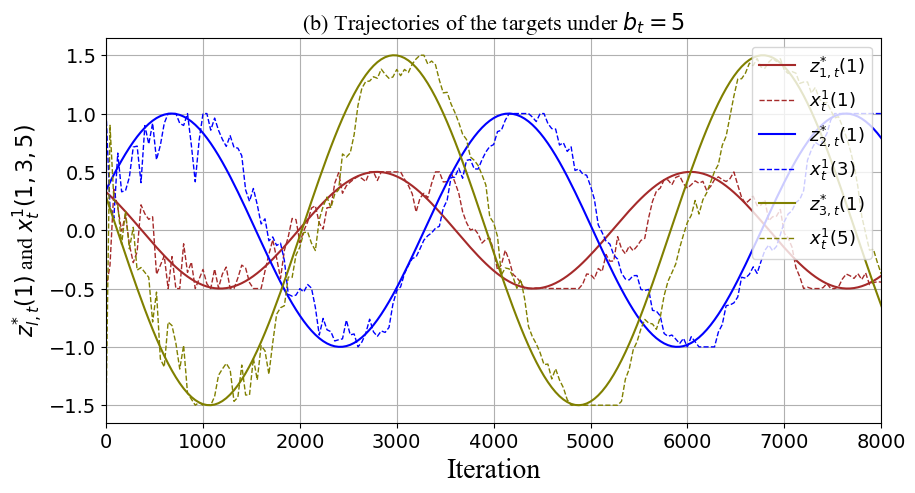

In [ ]:
names = ['$z_{1,t}^{*}(1)$', '$z_{2,t}^{*}(1)$', '$z_{3,t}^{*}(1)$']
alexs=['$x_{t}^{1}(1)$', '$x_{t}^{1}(3)$', '$x_{t}^{1}(5)$']
indices = [0,2,4]
markers = ['s','o','d','^','v','<','>']
colors = ['brown','blue','olive','peru','slategrey','burlywood','tan']
markers = markers[0:len(names)]
color_index = 0
plt.figure(figsize=(10, 5))
range_ = 4000
for name, alex, marker, color, indice in zip(names, alexs, markers, colors, indices):
    line = target(iter_num,dim=indice)[0:]
    line_track = track_ans(0, iter_num, dim=indice)[0:]
    interval = int(len(line) / (len(line)/ 40))
#     plt.semilogy(np.arange(len(line))[0:len(line):interval], line[0:len(line):interval], 
#                  linewidth=1.0, markersize=4, color=colors[color_index], 
#                  label=name)
    plt.plot(np.arange(len(line))[0:len(line):interval], line[0:len(line):interval], 
                 linewidth=1.5, markersize=4, color=colors[color_index], 
                 label=name)
    plt.plot(np.arange(len(line))[0:len(line):interval], line_track[0:len(line):interval], 
                 linewidth=1.0, markersize=4, color=colors[color_index], linestyle='--',
                 label=alex)
#     marker=marker,
    color_index+=1
# plt.legend(fontsize=16)
plt.legend(loc="upper right",fontsize=13)
plt.grid(True)
plt.xlabel('Iteration', fontsize=20, fontname='Times New Roman')
plt.ylabel(r'$z_{l,t}^{*}(1)$ and $x_{t}^{1}(1,3,5) $', fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 8000)
#plt.xlim(0, len(line))
#plt.ylim(-2, 2)
plt.title(f'(b) Trajectories of the targets under $b_t=5$', fontsize=16, fontname='Times New Roman')
plt.savefig('./graph1.pdf')
plt.show()

2、绘制dynamic_regret_sequence的图像

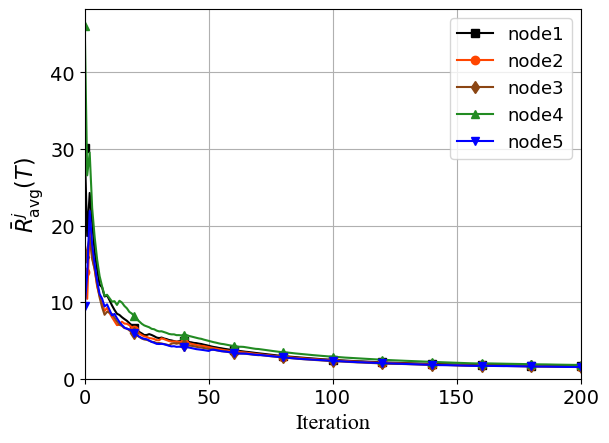

In [ ]:
names = [f'node{i+1}' for i in range(agent_num)]
indices = [0,2,4]
markers = ['s','o','d','^','v','<','>']
colors = ['black','orangered','saddlebrown','forestgreen','blue','brown','blue','olive','peru','tan','burlywood','slategrey']
markers = markers[0:len(names)]
index = 0
range_ = 100
for name, marker, color in zip(names, markers, colors):
    line = average_dynamic_regret_sequence(index,200)
    interval = int(len(line) /len(line))
    plt.plot(np.arange(len(line))[0:len(line):interval], line[0:len(line):interval], 
                 linewidth=1.5, markersize=6, markevery=20, marker=markers[index], color=colors[index], 
                label=name)  
#     plt.plot(np.arange(len(line))[0:len(line):interval], line[0:len(line):interval], 
#                  linewidth=1.0, markersize=4, color=colors[color_index], 
#                 label=name)
#     marker=marker,
    index+=1
# plt.legend(fontsize=16)
plt.legend(loc="upper right",fontsize=13)
plt.grid(True)
plt.xlabel('Iteration', fontsize=16, fontname='Times New Roman')
plt.ylabel(r'$\bar R^j_{\rm {avg}}(T)$', fontsize=16, fontname='Times New Roman')
x_ticks = np.linspace(0, 200, 5)  # 产生区间在-5至4间的10个均匀数值
#y_ticks = np.linspace(0, 100, 11) 
plt.xticks(x_ticks,fontsize=14)
#plt.yticks(y_ticks,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 200)
plt.ylim(0, None)
#plt.title(f'Trajectories of the targets',fontsize=20)
plt.savefig('./graph2.pdf')
plt.show()